In [ ]:
#import data related libraries
import pandas as pd
import numpy as np

# import plotting libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
# import modelling libraries, and statistical libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA as ARIMA


In [ ]:
df=pd.read_csv('/content/BTC-USD_hourly.csv')

<ipython-input-4-ad173c805812>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Close'] = df['Close'].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')
<ipython-input-4-ad173c805812>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')
<ipython-input-4-ad173c805812>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression='c')


Before Box-Cox Transformation:
KPSS Statistic: 19.657546997561447
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely non-stationary.

After Box-Cox Transformation:
KPSS Statistic: 20.760528998022785
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely non-stationary.


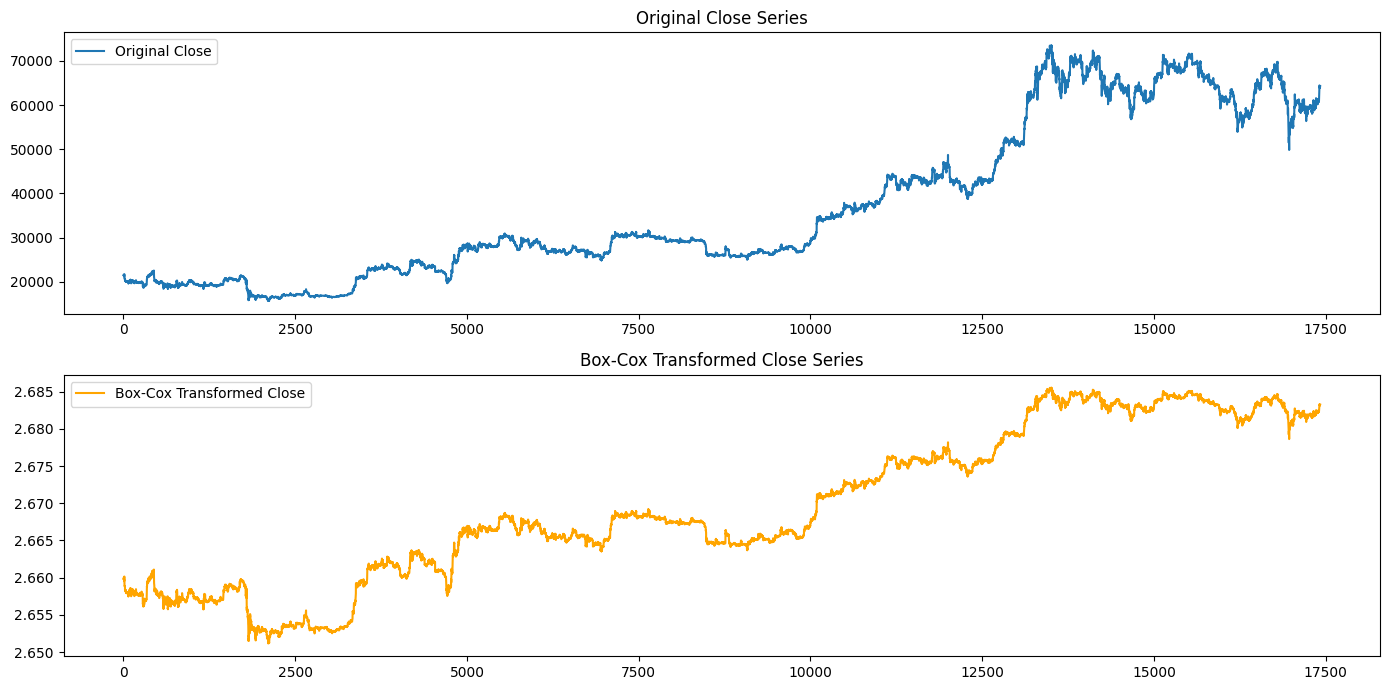

After Differencing of Box-Cox Transformed Series:
KPSS Statistic: 0.09416003242025814
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Data is likely stationary.


<ipython-input-4-ad173c805812>:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c')


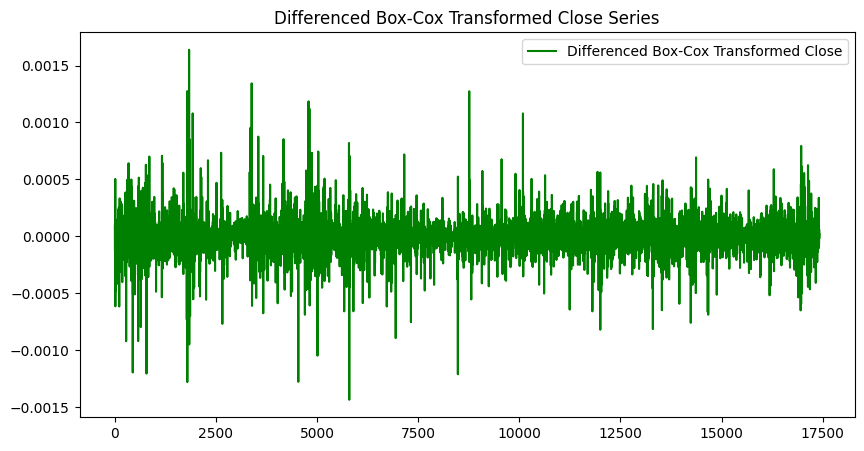

In [ ]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import kpss

# Ensure data is positive for Box-Cox
df['Close'] = df['Close'].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')

# Check stationarity using KPSS test
def check_stationarity_kpss(series):
    result = kpss(series.dropna(), regression='c')
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:', result[3])
    if result[1] < 0.05:
        print("Data is likely non-stationary.")
    else:
        print("Data is likely stationary.")

# Check stationarity of the 'Close' series before transformation
print("Before Box-Cox Transformation:")
check_stationarity_kpss(df['Close'])

# Apply Box-Cox transformation
df['Close_BoxCox'], lambda_param = boxcox(df['Close'])

# Check stationarity of the transformed 'Close' series
print("\nAfter Box-Cox Transformation:")
check_stationarity_kpss(df['Close_BoxCox'])

# Plot the original and transformed series
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Original Close')
plt.title('Original Close Series')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Close_BoxCox'], label='Box-Cox Transformed Close', color='orange')
plt.title('Box-Cox Transformed Close Series')
plt.legend()

plt.tight_layout()
plt.show()


# Apply differencing
df['Close_BoxCox_Diff'] = df['Close_BoxCox'].diff().dropna()

# Check stationarity of the differenced series
print("After Differencing of Box-Cox Transformed Series:")
check_stationarity_kpss(df['Close_BoxCox_Diff'].dropna())

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(df['Close_BoxCox_Diff'], label='Differenced Box-Cox Transformed Close', color='green')
plt.title('Differenced Box-Cox Transformed Close Series')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('path_to_your_combined_dataset.csv', index_col='Date', parse_dates=True)

# Select only the 'Close' column for Bitcoin
btc_close = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_scaled = scaler.fit_transform(btc_close)

# Define a function to create sequences of data
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

# Create sequences
seq_length = 60
x, y = create_sequences(btc_scaled, seq_length)

# Split the data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

The model is a sequential neural network with a Bidirectional LSTM layer followed by two stacked LSTM layers, each with 50 units, and Dropout for regularization, optimized using Adam with a learning rate of 0.001 to predict a single value from a sequence of 10 time steps and 14 features.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def build_improved_lstm_model(input_shape):
    model = Sequential()

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=input_shape)))
    model.add(Dropout(0.2))

    # Stacked LSTM layers
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


look_back = 10  # Number of previous time steps to use for predicting the next time step
num_features = 14  # Number of features in your input data

# Assuming X_train and y_train are prepared
model = build_improved_lstm_model(input_shape=(look_back, num_features))
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 5.9253e-05 - val_loss: 0.0024
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 4.9185e-05 - val_loss: 0.0025
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 4.2094e-05 - val_loss: 0.0012
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 3.8476e-05 - val_loss: 0.0053
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.7627e-05 - val_loss: 0.0021
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 3.6161e-05 - val_loss: 0.0028
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8991e-05 - val_loss: 0.0014
Epoch 9/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 3.2769e-05 - val_loss: 0.0019
Epoch 10/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 3.6244e-05 - val_loss: 0.0039
Epoch 11/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 3.4449e-05 - val_loss: 9.8054e-04
Epoc

In [ ]:
model.save('lstm_btc_V2.h5')